## HW2

In [1]:
print("Hello My World - Lets get this project done")

Hello My World - Lets get this project done


In [2]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [3]:

# Display 5 images from metal and paper datasets along with their sizes
for i, (metal_file, paper_file) in enumerate(zip(os.listdir("Dataset/metal")[:5], os.listdir("Dataset/paper")[:5])):
    metal_path = os.path.join("Dataset/metal", metal_file)
    paper_path = os.path.join("Dataset/paper", paper_file)
    
    try:
        metal_image = Image.open(metal_path)
        paper_image = Image.open(paper_path)
        
        print(f"Metal Image {i+1} Size: {metal_image.size}")
        print(f"Paper Image {i+1} Size: {paper_image.size}")
    except Exception as e:
        print(f"Error loading image {i+1}: {e}")

Metal Image 1 Size: (259, 194)
Paper Image 1 Size: (275, 183)
Metal Image 2 Size: (225, 225)
Paper Image 2 Size: (512, 384)
Metal Image 3 Size: (512, 384)
Paper Image 3 Size: (205, 246)
Metal Image 4 Size: (266, 190)
Paper Image 4 Size: (512, 384)
Metal Image 5 Size: (512, 384)
Paper Image 5 Size: (512, 384)


In [4]:
# Load and preprocess images
def load_images_from_folder(folder, label, image_size=(64, 64)):
    images, labels = [], []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        try:
            img = Image.open(img_path).convert('RGB')
            img = img.resize(image_size)
            img_array = np.array(img).flatten() / 255.0
            images.append(img_array)
            labels.append(label)
        except:
            continue
    return images, labels

In [5]:

metal_imgs, metal_labels = load_images_from_folder("Dataset/metal", 0)
paper_imgs, paper_labels = load_images_from_folder("Dataset/paper", 1)
print(f"Metal images - Label 1 : {len(metal_imgs)}")
print(f"Paper images - Label 2 : {len(paper_imgs)}")
# Combine and shuffle
X = np.array(metal_imgs + paper_imgs)
Y = np.array(metal_labels + paper_labels)

print(f"Total samples: {len(Y)}, Metal: {sum(Y==0)}, Paper: {sum(Y==1)}")

# Split: Train (60%), Validation (20%), Test (20%)
X_trainval, X_test, y_trainval, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=42, stratify=y_trainval)

print(f"Train: {len(y_train)}, Validation: {len(y_val)}, Test: {len(y_test)}")


Metal images - Label 1 : 769
Paper images - Label 2 : 1050
Total samples: 1819, Metal: 769, Paper: 1050
Train: 1091, Validation: 364, Test: 364


In [6]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

train_acc = accuracy_score(y_train, logreg.predict(X_train))
test_acc = accuracy_score(y_test, logreg.predict(X_test))
val_acc = accuracy_score(y_val, logreg.predict(X_val))

print(f"Logistic Regression - Train Acc: {train_acc:.3f}, Test Acc: {test_acc:.3f}, Val Acc: {val_acc:.3f}")


Logistic Regression - Train Acc: 0.998, Test Acc: 0.698, Val Acc: 0.681


In [7]:
nn1 = MLPClassifier(hidden_layer_sizes=(4,), max_iter=200, random_state=1)
nn1.fit(X_train, y_train)

train_acc = accuracy_score(y_train, nn1.predict(X_train))
test_acc = accuracy_score(y_test, nn1.predict(X_test))
val_acc = accuracy_score(y_val, nn1.predict(X_val))

print(f"1 Hidden Layer (4 units) - Train Acc: {train_acc:.3f}, Test Acc: {test_acc:.3f}, Val Acc: {val_acc:.3f}")


1 Hidden Layer (4 units) - Train Acc: 0.577, Test Acc: 0.577, Val Acc: 0.577


In [8]:
nn2 = MLPClassifier(hidden_layer_sizes=(7, 4), max_iter=200, random_state=1)
nn2.fit(X_train, y_train)

train_acc = accuracy_score(y_train, nn2.predict(X_train))
test_acc = accuracy_score(y_test, nn2.predict(X_test))
val_acc = accuracy_score(y_val, nn2.predict(X_val))

print(f"2 Hidden Layers (7+4 units) - Train Acc: {train_acc:.3f}, Test Acc: {test_acc:.3f}, Val Acc: {val_acc:.3f}")


2 Hidden Layers (7+4 units) - Train Acc: 0.830, Test Acc: 0.712, Val Acc: 0.695


In [9]:
def preprocess_image(img_path, image_size=(64, 64)):
    img = Image.open(img_path).convert('RGB')
    img = img.resize(image_size)
    img_array = np.array(img).flatten() / 255.0
    return img_array.reshape(1, -1)  # reshape for prediction

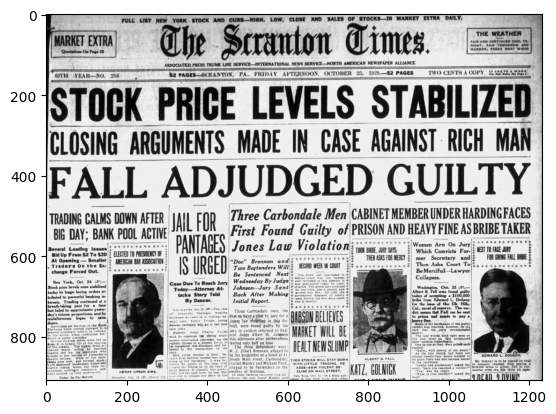

In [16]:
image_path = "test.jpg"
IMG = Image.open(image_path)
plt.imshow(IMG)
uploaded_img = preprocess_image(image_path)

In [11]:
logreg_pred = logreg.predict(uploaded_img)[0]
print("Logistic Regression Prediction:", "Paper" if logreg_pred == 1 else "Metal")

Logistic Regression Prediction: Paper


In [12]:
nn1_pred = nn1.predict(uploaded_img)[0]
print("NN (1 Hidden Layer) Prediction:", "Paper" if nn1_pred == 1 else "Metal")


NN (1 Hidden Layer) Prediction: Paper


In [13]:
nn2_pred = nn2.predict(uploaded_img)[0]
print("NN (2 Hidden Layers) Prediction:", "Paper" if nn2_pred == 1 else "Metal")


NN (2 Hidden Layers) Prediction: Paper
